## Import necessary libraries

In [1]:
import numpy as np
from PIL import Image
import torch
from scipy.stats import multivariate_normal
from IPython.display import display
import matplotlib.pyplot as plt

# Task 1: Simple Image Operations

### 1. Load image

In [2]:
image = np.array(Image.open('Capybara.jpg'))

### 2. Print width, height, and number of channels and plot the image

(600, 800, 3)



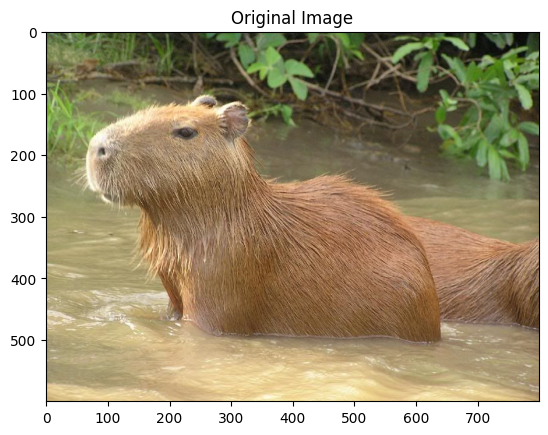

In [3]:
print(image.shape)
plt.imshow(image)
plt.title('Original Image')
print()

### 3. Crop a random patch of size 256x256 from the image

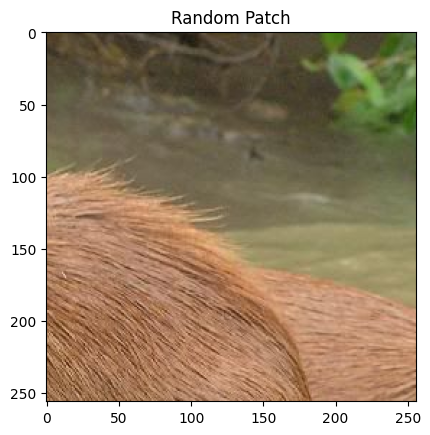

In [4]:
random_x = np.random.randint(0, image.shape[0] - 256)
random_y = np.random.randint(0, image.shape[1] - 256)

patch = image[random_x:random_x + 256, random_y:random_y + 256]
plt.imshow(patch)
plt.title("Random Patch")
print()


### 4. Convert the image patch to grayscale

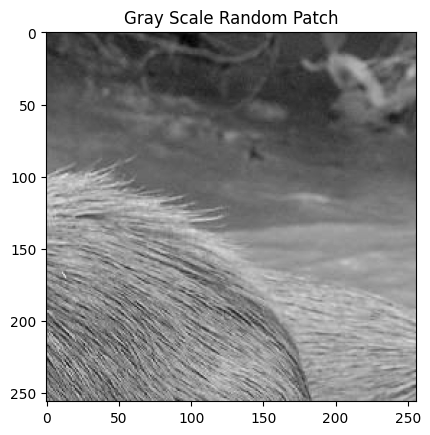

In [5]:
gray_scale_patch = np.dot(patch[..., :3], [0.2989, 0.5870, 0.1140])
np.clip(gray_scale_patch, 0, 255)
plt.imshow(gray_scale_patch, cmap='gray')
plt.title("Gray Scale Random Patch")
print()

### 5. Insert the grayscale patch back into the original image

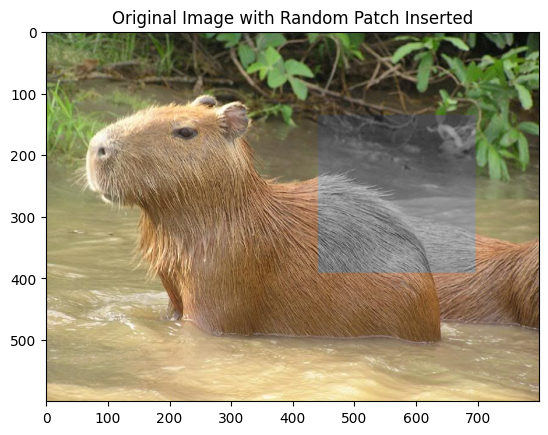

In [6]:
original_image_with_patch = np.copy(image)
original_image_with_patch[random_x:random_x + 256, random_y:random_y + 256, :] = np.stack((gray_scale_patch,) * 3, axis=-1)
plt.imshow(original_image_with_patch)
plt.title("Original Image with Random Patch Inserted")
print()

### 6. Resize the image with the inserted gray patch 

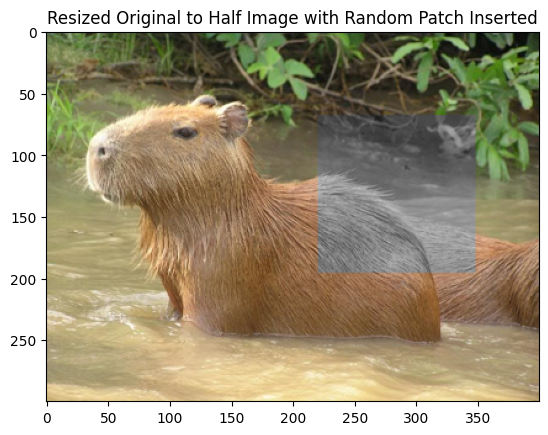

In [7]:
original_image_with_patch_resized = Image.fromarray(original_image_with_patch).resize((image.shape[1] // 2, image.shape[0] // 2))
plt.imshow(original_image_with_patch_resized)
plt.title("Resized Original to Half Image with Random Patch Inserted")
print()

# Task 2: Convolution and Filters

### Utils
take care of the range of the value before plot the images

In [8]:
def display_img(x, norm=False):
    """
    Displays image
    """
    x = np.copy(x)
    # Normalize if necessary
    if norm:
        x = (x - np.min(x)) / (np.max(x) - np.min(x))
    # Scale and convert to uint8 format for PIL plotting
    x *= 255
    x = x.astype(np.uint8)
    # Handle channel dimension
    if len(x.shape) == 2:
        x = x[:, :, np.newaxis]
    if x.shape[2] == 1:
        x = np.repeat(x, 3, axis=2)

    display(Image.fromarray(x))

def load_img(path, grayscale=False):
    """
    Loads image from given path, converts to float and normalize to [0,1] interval
    """
    img = Image.open(path)
    a = np.asarray(img, dtype=np.float32) / 255
    # Convert to grayscale if necessary
    if grayscale:
        a = np.mean(a, axis=2, keepdims=True)
    return a

### 1. Implement convolution operation

In [9]:
def conv2d(x, kernel):
    """
        Performs a 2D convolution operation with a single kernel.
        Args:
            x      (array): the input array of shape (H, W).
            kernel (array): the kernel that is convolved over the input.
        Returns:
            out    (array): the output array.
    """
    image_height, image_width = x.shape
    kernel_height, kernel_width = kernel.shape
    
    out_shape = (image_height - kernel_height + 1, image_width - kernel_width + 1)
    out = np.zeros(out_shape)
    
    for height in range(out_shape[0]):
        for width in range(out_shape[1]):
        
            roi = x[height:height + kernel_height, width:width + kernel_width]
            out[height, width] = np.sum(roi * kernel)
            
    return out 


### 2. Implement a Gaussian filter


Sum without normalization:  0.99686881728023
Sum with normalization:  0.9999999999999999



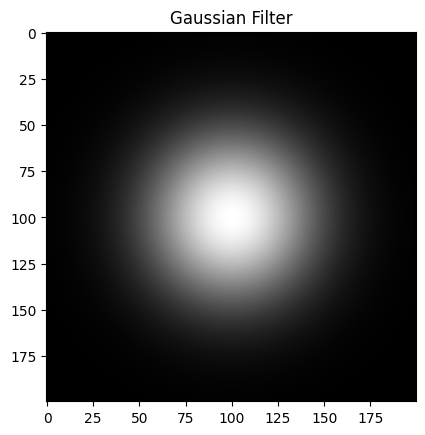

In [10]:
def gaussian_filter(size, mean=0, var=1000):
    """
        Returns an isotropic Gaussian filter.
        Args:
            size       (int): the size of the kernel.
            mean (float/int): the mean of the Gaussian.
            var  (float/int): the variance of the Gaussian.
        Returns:
            f        (array): the Gaussian filter of shape (size, size).
    """
    rows, columns = np.indices((size, size))
    rows -= size // 2
    columns -= size // 2
    
    squared_sums = rows**2 + columns**2
    
    f = np.exp(-squared_sums / (2*var)) / (2*np.pi*var)
    print("Sum without normalization: ", np.sum(f))
    
    f /= np.sum(f)
    print("Sum with normalization: ", np.sum(f))
    
    return f

f = gaussian_filter(size=200, mean=0, var=1000)
plt.imshow(f, cmap='gray')
plt.title('Gaussian Filter')
print()

### 3. Apply Gaussian filter to image

Sum without normalization:  0.9943279280513163
Sum with normalization:  1.0



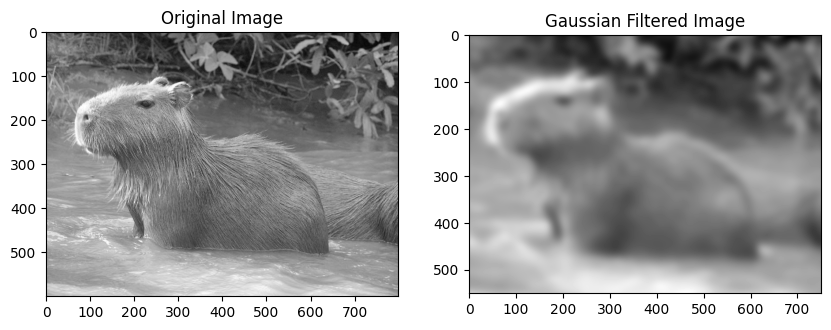

In [11]:
plt.figure(figsize=(10, 10))


black_and_white = np.array(Image.open('Capybara.jpg').convert('L'))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(black_and_white, cmap="gray")


gaussian_kernel = gaussian_filter(size=50,mean=0,var=70)
gaussian_filtered_normalized_image = conv2d(black_and_white, gaussian_kernel)
gaussian_filtered_image = gaussian_filtered_normalized_image * 255
plt.subplot(1, 2, 2)
plt.title('Gaussian Filtered Image')
plt.imshow(gaussian_filtered_image, cmap="gray")

print()

### 4. Implement and apply Laplacian filter to image

Hint: If you only apply laplacian and use plt to plot without taking care of the value range, you would probably have a hard time to see something

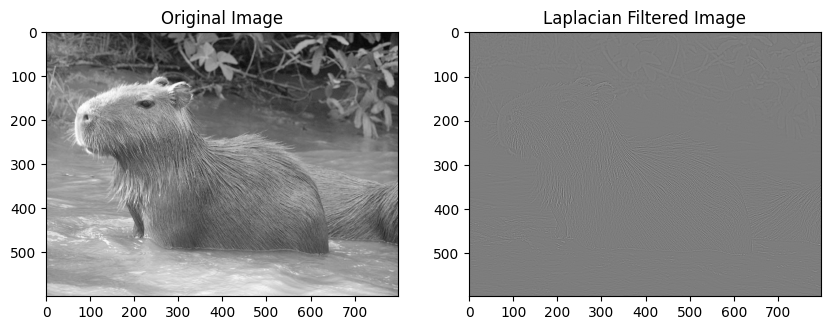

In [12]:
laplacian_kernel = np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]])
laplacian_filtered_image = conv2d(black_and_white, laplacian_kernel)
laplacian_filtered_image = (laplacian_filtered_image - np.min(laplacian_filtered_image)) / (np.max(laplacian_filtered_image) - np.min(laplacian_filtered_image)) * 255

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(black_and_white, cmap="gray")

plt.subplot(1, 2, 2)
plt.title('Laplacian Filtered Image')
plt.imshow(laplacian_filtered_image, cmap="gray", vmin=0, vmax=255)

print()

#### How does the Laplacian Filter detects the edges?
Laplacian filter mainly computes the second derivative of the image. Hence it calculates the sudden changes between the pixels. It represents the rate of change of intensity across the image.

In the edges of the objects, the pixel intensity changes rapidly due to every object having different kind of pixel distribution. This rapidness causes high values as the output of the laplacian convolution. 

As the middle and corners having different signs, the laplacian filter can catch the sudden changes of intensity. Because it catches how the pixels change from dark to light and dark to light.

### 5. Problems with handcrafted filters

* They run slow, probably not that much optimized. (This is more about my convolution implementation.)
* Problems in training, they cannot be trained that well since there is no trainable parameter in the kernel, since the kernel is static.
* Hence they *may* not generalize over the training data if there are complex patterns
* Although they are good at edge detection, blurring, reversing the channels etc., learning the important features of the complex images *may* be complex and tidious with only handcrafted filters. We might need learnable filters to be able to identify the important features of the image, and shrink down the image to the important features vector space with the help of convolutions.
 

# Task 3: Introduction to PyTorch

### 1. Convert NumPy array to PyTorch tensor and vice versa

In [13]:
img_array = np.copy(image)
print("Type and shape of original array: \t\t", img_array.shape,"\t\t\t\t", type(img_array))

img_tensor = torch.tensor(img_array, dtype=torch.float32)
print("Type and shape of tensor: \t\t\t",img_tensor.shape, "\t\t", type(img_tensor))

img_tensor = img_tensor.permute(2, 0, 1)
print("Type and shape of tensor after permutation: \t", img_tensor.shape, "\t\t", type(img_tensor))

img_tensor = img_tensor.permute(1,2,0)
print("Type and shape of tensor after permutation: \t", img_tensor.shape, "\t\t",type(img_tensor))

img_array = img_tensor.numpy()
print("Type and shape of array converted from tensor: \t", img_array.shape, "\t\t\t\t", type(img_array))

image = Image.fromarray(img_array.astype(np.uint8))
image.save("Capybara_Saved.jpg")
print("Capybara saved!")

Type and shape of original array: 		 (600, 800, 3) 				 <class 'numpy.ndarray'>
Type and shape of tensor: 			 torch.Size([600, 800, 3]) 		 <class 'torch.Tensor'>
Type and shape of tensor after permutation: 	 torch.Size([3, 600, 800]) 		 <class 'torch.Tensor'>
Type and shape of tensor after permutation: 	 torch.Size([600, 800, 3]) 		 <class 'torch.Tensor'>
Type and shape of array converted from tensor: 	 (600, 800, 3) 				 <class 'numpy.ndarray'>
Capybara saved!


### 2. Create a PyTorch convolution operator

In [14]:
x = np.random.random((5,5,1))
w = np.random.random((2,2,1))

conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, stride=1, padding=0, bias=False)

x = torch.tensor(x, dtype=torch.float32).permute(2,0,1)
w = torch.tensor(w, dtype=torch.float32).permute(2,0,1)

x = x.unsqueeze(0)
w = w.unsqueeze(0)

conv.weight = torch.nn.Parameter(w)
output = conv(x)

print("Output of torch convolution operator: \n", output)

Output of torch convolution operator: 
 tensor([[[[0.7940, 0.7182, 0.5040, 1.2464],
          [1.3372, 0.6122, 0.3959, 0.7976],
          [1.2671, 0.5311, 0.5878, 0.9725],
          [1.7835, 0.6483, 0.1263, 1.0162]]]], grad_fn=<ConvolutionBackward0>)


In [15]:
output = conv2d(x.squeeze().numpy(), w.squeeze().numpy())
print("Output of my convolution operator: \n", output)

Output of my convolution operator: 
 [[0.7939716  0.71817791 0.50398141 1.24642169]
 [1.33723819 0.61222541 0.39586782 0.79764664]
 [1.26713121 0.53113419 0.58781087 0.97247374]
 [1.78354478 0.64828169 0.12634936 1.01623619]]


### 3. Apply Gaussian filter using nn.Conv2d

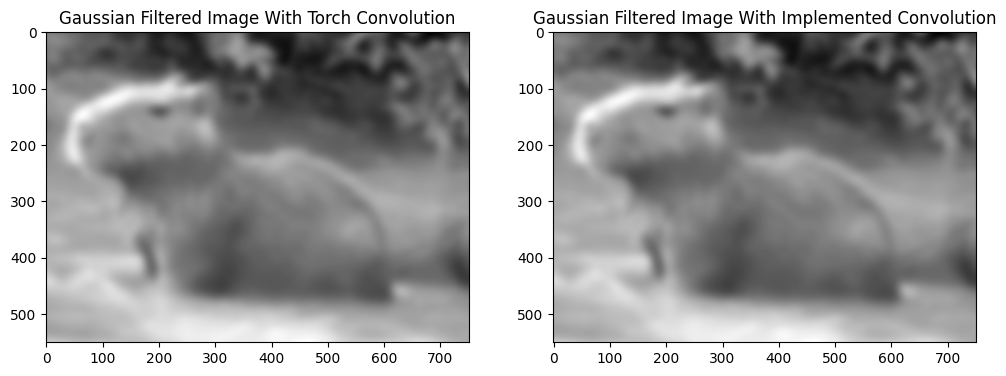

In [16]:
gaussian_kernel = gaussian_kernel.reshape(1, 1, 50, 50)
gaussian_kernel = torch.tensor(gaussian_kernel, dtype=torch.float32)

black_and_white = black_and_white.reshape(1, 1, 600, 800)
black_and_white = torch.tensor(black_and_white, dtype=torch.float32)

conv.weight = torch.nn.Parameter(gaussian_kernel)
output = conv(black_and_white)

np_output = output.squeeze().detach().numpy()

plt.figure(figsize=(12, 12))

plt.subplot(1, 2, 2)
plt.title('Gaussian Filtered Image With Implemented Convolution')
plt.imshow(gaussian_filtered_image, cmap="gray")

plt.subplot(1, 2, 1)
plt.title('Gaussian Filtered Image With Torch Convolution')
plt.imshow(np_output, cmap="gray")

print()